# Amazon Product Review Feature Engineering Notebook

The purpose of this notebook is to perform some feature engineering on the Amazon Product Review Data. The overall scope of this project is to determine if product reviews on Amazon.com have any sort of impact on the overall sales ranking of any particular item. The data was obtain with permission from the following paper:

Justifying recommendations using distantly-labeled reviews and fined-grained aspects
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019

In [1]:
#First import some packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
#First load the data

rev = pd.read_csv('Data/ProcessedAmazonReviewData200k.csv', index_col=False)
rev.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,category,title,brand,rank,main_cat,price,rankCat,catRank,Ranking,salesRanking,ratingPrice
0,5.0,True,"01 27, 2016",A2GK1C4FOZK7RO,B003TDUBL8,Gina Marie,Great!,Five Stars,1453852800,"['Home & Kitchen', 'Home Dcor', 'Area Rugs, Ru...",Grip-It Ultra Stop Non-Slip Rug Pad for Rugs o...,Grip-It,"['>#6,064 in Home & Kitchen (See top 100)', '>...",Amazon Home,49.90,"[""6,064 in Home & Kitchen (See top 100)', '"", ...","16 in Home & Kitchen > Home Dcor > Area Rugs, ...",16.0,50.0,249.50
1,5.0,True,"10 25, 2017",A2NO2EBP7YSUDI,B003TDUBL8,Susan,Just as described.,Good,1508889600,"['Home & Kitchen', 'Home Dcor', 'Area Rugs, Ru...",Grip-It Ultra Stop Non-Slip Rug Pad for Rugs o...,Grip-It,"['>#6,064 in Home & Kitchen (See top 100)', '>...",Amazon Home,49.90,"[""6,064 in Home & Kitchen (See top 100)', '"", ...","16 in Home & Kitchen > Home Dcor > Area Rugs, ...",16.0,50.0,249.50
2,3.0,True,"10 14, 2016",A20R2UXN0ZPL9D,B001892AX2,sandiibb,Not thrilled with this product. I gave a ratin...,Think twice about ordering the large salt light,1476403200,"['Home & Kitchen', 'Home Dcor', 'Candles & Hol...","Himalayan Glow 1002 Pink Crystal Salt Lamp, (8...",Himalayan Glow,['>#44 in Tools & Home Improvement (See top 10...,Tools & Home Improvement,19.99,"[""44 in Tools & Home Improvement (See top 100)...",1 in Tools & Home Improvement > Lighting & Cei...,1.0,65.0,59.97
3,2.0,False,"09 20, 2016",A1ZE46TUGN1NBZ,B00GGMFK9M,K. Brooks,"I loved this, when it worked. Unfortunately, a...",Stopped working after a month,1474329600,"['Home & Kitchen', 'Kitchen & Dining', 'Kitche...",Lavatools PT12 Javelin Digital Instant Read Me...,Lavatools,['>#323 in Kitchen & Dining (See Top 100 in Ki...,Amazon Home,26.99,"[""323 in Kitchen & Dining (See Top 100 in Kitc...",8 in Kitchen & Dining > Kitchen Utensils & Gad...,8.0,58.0,53.98
4,5.0,True,"07 26, 2016",A2O8MVTKF9S8FA,B004GNGID0,Heather and Ryne Griffith,"We drink a lot of water at house, so buy water...",Best purchase!,1469491200,"['Home & Kitchen', 'Kitchen & Dining', 'Dining...",Brita Large 10 Cup Water Filter Pitcher with 1...,Brita,"['>#10,887 in Kitchen & Dining (See Top 100 in...",Amazon Home,37.99,"[""10,887 in Kitchen & Dining (See Top 100 in K...",27 in Home & Kitchen > Kitchen & Dining > Wate...,27.0,39.0,189.95


The first feature to add to the data set will be the average rating for each product. However, due to the volume of items available on the Amazon marketplace, I suspect there will be quite a few items that will only have one review. We'll take a look at the number of unique items and the overall number of items. 

In [3]:
print('The number of duplicate reviews is:', rev.shape[0]-len(rev['asin'].unique()))
print('The number of unique items reviewed is:', len(rev.asin.unique()))

The number of duplicate reviews is: 145989
The number of unique items reviewed is: 281


In [4]:
rev.main_cat.value_counts()

Amazon Home                 142940
Tools & Home Improvement      1728
Health & Personal Care         460
All Beauty                     386
Automotive                     385
Industrial & Scientific        371
Name: main_cat, dtype: int64

In [5]:
#In order to ensure the I want to ignore any categories that only appear a couple times. This will ensure that there are no
#surprise categorical variables in the split data set.
filtered = rev.groupby('main_cat')['asin'].filter(lambda x: len(x) > 80)
rev = rev[rev['asin'].isin(filtered)]

It appears about half of the products have been reviewed more than once, but that shouldn't be an issue for this review. I'll calculate the average rating as well as the count of the reviews. 

In [6]:
rev['AvgRating'] = rev['overall'].groupby(rev.asin).transform('mean')
rev['RatingCount'] = rev['overall'].groupby(rev.asin).transform('sum')

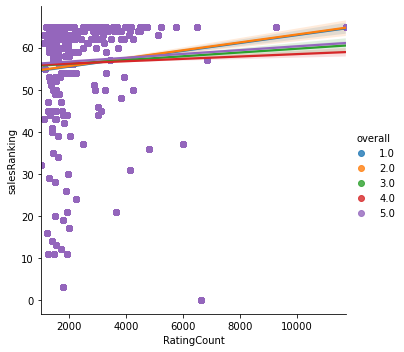

In [7]:
sns.lmplot(x = 'RatingCount', y = 'salesRanking', data = rev, hue = 'overall')


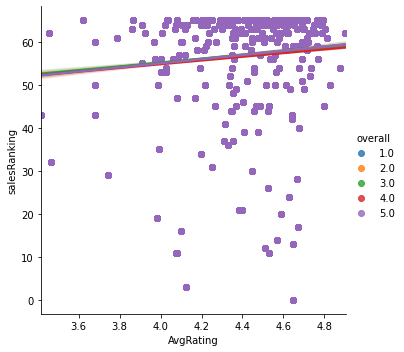

In [8]:
sns.lmplot(x='AvgRating', y = 'salesRanking', data = rev, hue = 'overall')

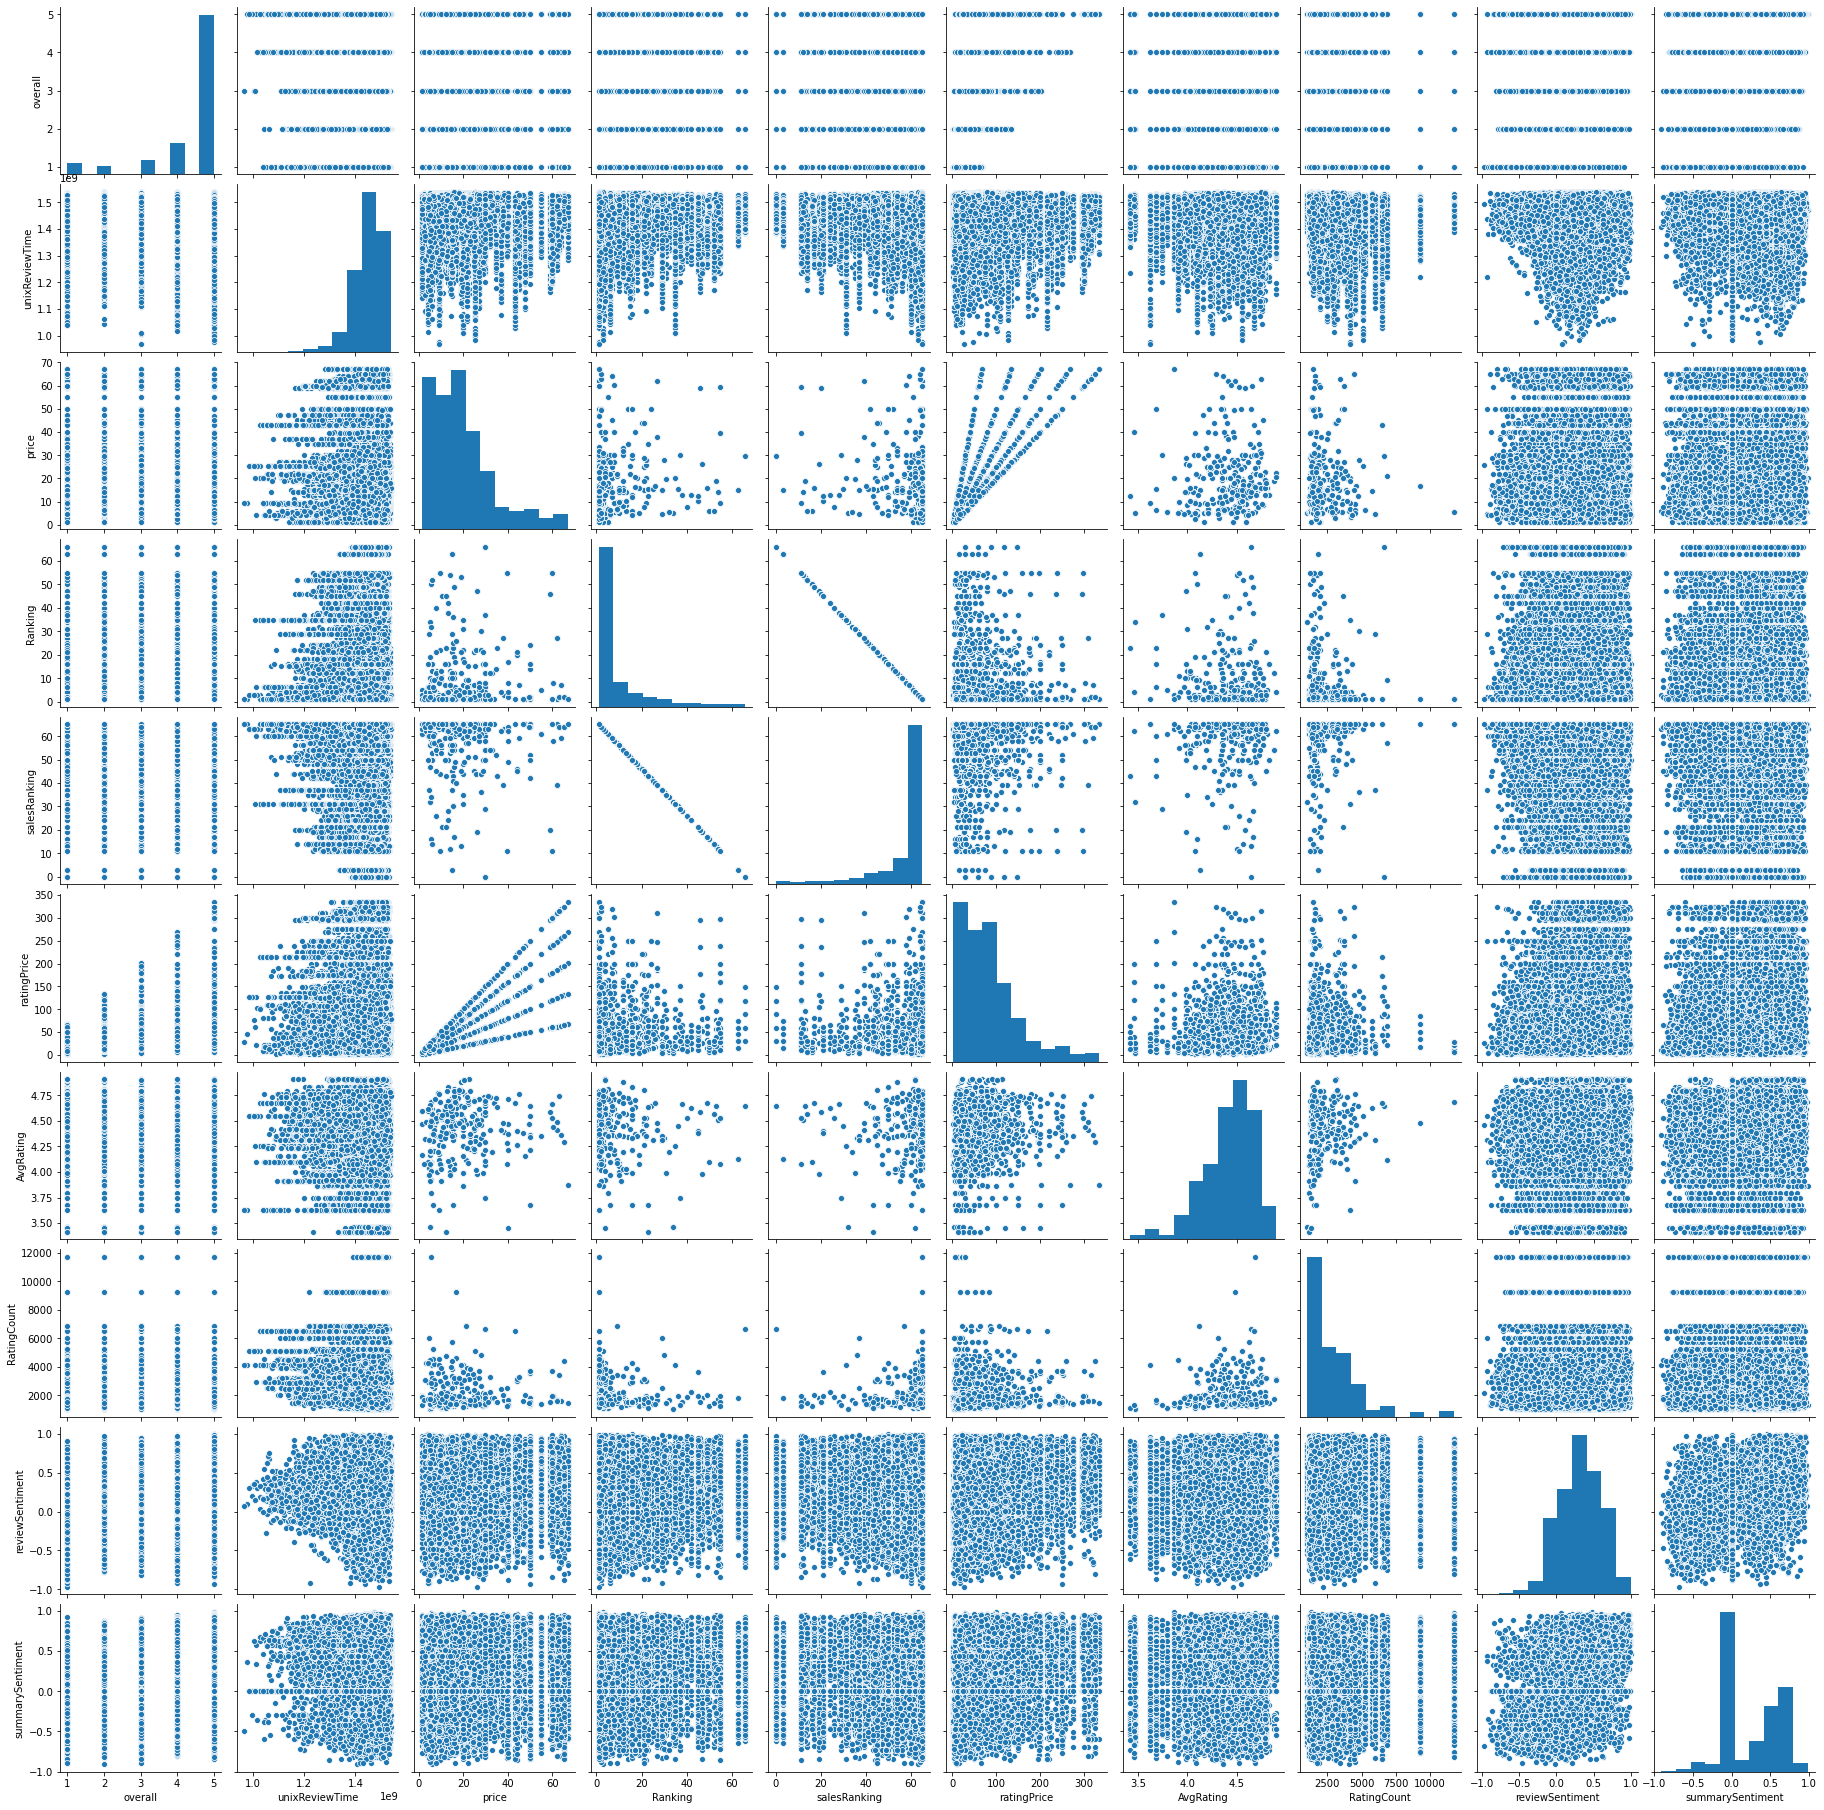

In [14]:
sns.pairplot(rev.drop('verified', axis = 1))

Next I want to create a continuous variable to reflect the sentiment of the review. 
This function will utilize the VADER sentiment analyzer and will average the sentiment of all sentances
in the review. The final variable will be the average of the compound score reported by VADER.

In [10]:
#First I need to import the subjectivity and VADER packages from nltk
import nltk
from nltk.corpus import subjectivity
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#The function creates an instance of the sentiment analyzer and tokenizes the review into sentances. 
#the sentiment of each sentance is stored in a list and the mean of the compound score is taken and returned. 
#If the review contains no text, then 0 is returned (equivalent of a neutral review)
def getSentiment(review):
    sid = SentimentIntensityAnalyzer()
    if len(review) == 0:
        return 0
    elif len(tokenize.sent_tokenize(review)) == 1:
        return sid.polarity_scores(review)['compound']
    sentiment = []
    for sentance in tokenize.sent_tokenize(review):
        ss = sid.polarity_scores(sentance)
        sentiment.append(ss['compound'])
    return np.mean(sentiment)

In [11]:
#Now apply the function to the dataframe and store the results in a new column. 
rev['reviewSentiment'] = rev['reviewText'].apply(getSentiment)

In [12]:
#Next I'd like to get the sentiment of the summary. Hopefully these values are similar...
rev['summarySentiment'] = rev['summary'].apply(getSentiment)

In [13]:
rev.summarySentiment.fillna(value = 0, inplace = True)
pd.isnull(rev).sum()

overall             0
verified            0
reviewTime          0
reviewerID          0
asin                0
reviewerName        0
reviewText          0
summary             0
unixReviewTime      0
category            0
title               0
brand               0
rank                0
main_cat            0
price               0
rankCat             0
catRank             0
Ranking             0
salesRanking        0
ratingPrice         0
AvgRating           0
RatingCount         0
reviewSentiment     0
summarySentiment    0
dtype: int64

In [15]:
rev.dropna(axis=0, how = 'any', inplace = True)

In [16]:
rev.describe()

,overall,unixReviewTime,price,Ranking,salesRanking,ratingPrice,AvgRating,RatingCount,reviewSentiment,summarySentiment
count,146270.000000,1.462700e+05,146270.000000,146270.000000,146270.000000,146270.000000,146270.000000,146270.000000,146270.000000,146270.000000
mean,4.417775,1.448463e+09,19.465980,9.038805,56.961195,86.246956,4.417775,2989.760853,0.317406,0.260044
std,1.098511,5.640548e+07,13.986848,13.098587,13.098587,67.117025,0.259388,1913.258339,0.272261,0.327486
min,1.000000,9.681120e+08,1.360000,1.000000,0.000000,1.360000,3.415663,1018.000000,-0.967400,-0.908100
25%,4.000000,1.419811e+09,8.990000,1.000000,56.000000,33.550000,4.271478,1690.000000,0.130154,0.000000
50%,5.000000,1.455408e+09,15.970000,3.000000,63.000000,73.850000,4.460425,2345.000000,0.318450,0.226300
75%,5.000000,1.488067e+09,25.490000,10.000000,65.000000,114.950000,4.611472,3729.000000,0.517162,0.599400
max,5.000000,1.538266e+09,67.000000,66.000000,65.000000,335.000000,4.905132,11708.000000,0.995700,0.985700


In [17]:
#Next I want to create a variable to capture the length of the review to determine if the length has any impact on the Ranking. 

#Create a regex tokenizer to drop punctuation
tokenizer = nltk.RegexpTokenizer(r"\w+")
#Now apply the tokenizer to each review and count the lenth
rev['reviewLength'] = rev['reviewText'].apply(lambda x: len(tokenizer.tokenize(x)) if len(x) > 0 else 0)

<AxesSubplot:>

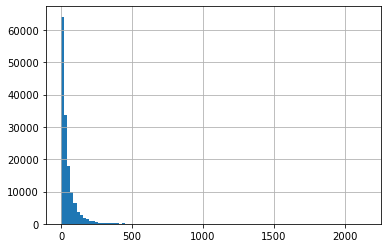

In [18]:
#Lets have a look at the results:
rev['reviewLength'].hist(bins=100)

In [19]:
#Lastly I need to convert 'verified' from boolean to binary.

rev.verified.replace({True:1, False:0}, inplace=True)

I'm curious to see if there are any hidden patterns in the data that I can use as a predictor variable. I'll use the KMeans clustering algorithm from sklearn to engineer some clusters. The first step will be to determine the number of clusters to use. I'll accomplish this using the elbow plot method. First I need to create an X vector for the KMeans algorithm. Then I'll test the variance explained by 1 to 50 clusters. Once we have the clusters we can append them to the data and look for interaction terms.

In [20]:
#First I need to prepare the data for the KMeans algorithm. I'll start by dropping categorical columns. 
#I also need to split the data into train and test groups. 

x_train, x_test, y_train, y_test = train_test_split(rev.drop(['salesRanking'], axis=1), rev.salesRanking, )

obs = []
[obs.append(col) for col in x_train.columns if rev[col].dtype == 'O']
xClf = x_train.drop(obs, axis = 1)

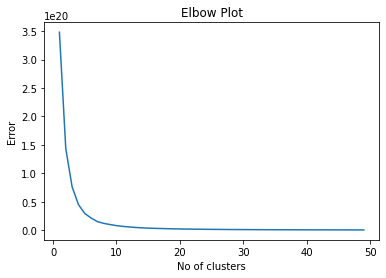

In [21]:
#Run through the number of clusters ranging form 1 to 50. 

from sklearn.cluster import KMeans
Error = []
for i in range(1, 50):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(xClf)
    Error.append(kmeans.inertia_)
plt.plot(range(1, 50), Error)
plt.title('Elbow Plot')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

In [22]:
#I'll plan to use 8 clusters. Now I need to generate the features and append them to the dataframe. 
kmeans = KMeans(n_clusters = 8, random_state = 123)
kmeans.fit(xClf)
clusters = kmeans.predict(xClf)
x_train['clusters'] = clusters

In [23]:
x_train.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'category',
       'title', 'brand', 'rank', 'main_cat', 'price', 'rankCat', 'catRank',
       'Ranking', 'ratingPrice', 'AvgRating', 'RatingCount', 'reviewSentiment',
       'summarySentiment', 'reviewLength', 'clusters'],
      dtype='object')

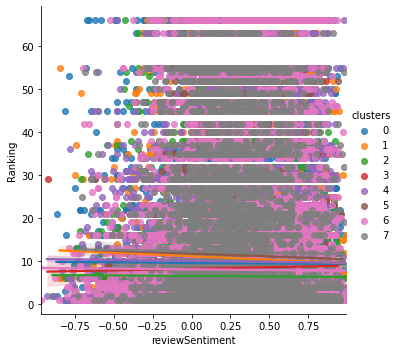

In [24]:
#Looks good. 
sns.lmplot(x='reviewSentiment', y = 'Ranking', data = x_train, hue = 'clusters')

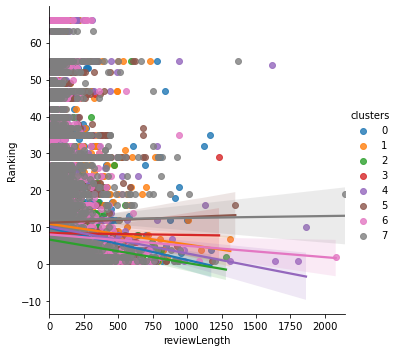

In [25]:
sns.lmplot(x='reviewLength', y = 'Ranking', data = x_train, hue = 'clusters')
#It looks like the ranking decreases as the reviews become increasingly verbose. 

In [26]:
#I'll go ahead and create an interaction term for cluster_reviewLength
x_train['clusterXreviewLength'] = x_train['clusters']*x_train['reviewLength']

Text(0.5, 1.0, 'Ranking vs Price varying by cluster')

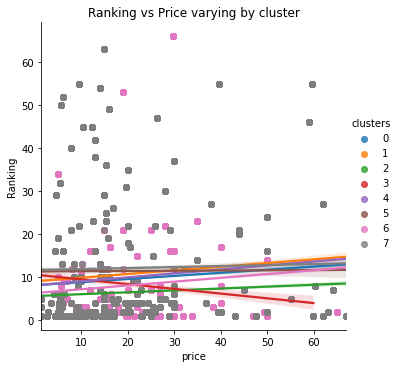

In [27]:
#Now I'll look for interaction terms using the clusters. 
#If the slopes or intercepts vary by cluster for ranking vs the other continuous variables then there are likely interactions
sns.lmplot(x = 'price', y = 'Ranking', hue = 'clusters', data = x_train)
plt.title('Ranking vs Price varying by cluster')

In [28]:
#There may also be an interaction between price and cluster. I'll create an interaction term there as well.
x_train['clusterXprice'] = x_train['clusters']*x_train['price']

Text(0.5, 1.0, 'Ranking vs overall rating varying by cluster')

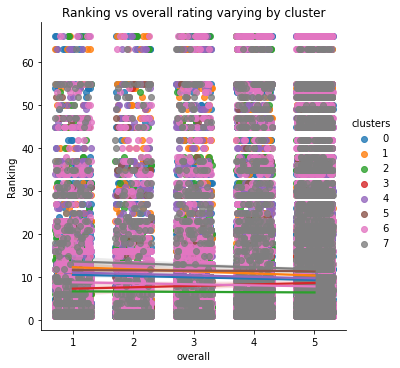

In [29]:
sns.lmplot(x = 'overall', y = 'Ranking', hue = 'clusters', data = x_train, x_jitter = 0.3)
plt.title('Ranking vs overall rating varying by cluster')

In [30]:
#There may also be an interaction between cluster and overall
x_train['clusterXprice'] = x_train['clusters']*x_train['price']

Text(0.5, 1.0, 'Ranking vs AvgRating varying by cluster')

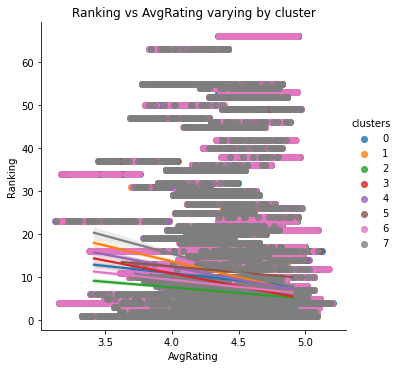

In [31]:
sns.lmplot(x = 'AvgRating', y = 'Ranking', hue = 'clusters', data = x_train, x_jitter = 0.3)
plt.title('Ranking vs AvgRating varying by cluster')

In [32]:
#Create an interaction term between cluster and average rating
x_train['clusterXavgRating'] = x_train['clusters']*x_train['AvgRating']

Text(0.5, 1.0, 'salesRanking vs RatingCount varying by cluster')

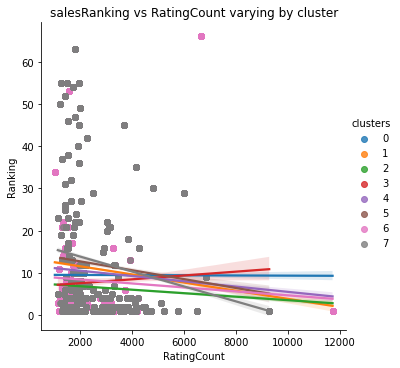

In [33]:
sns.lmplot(x = 'RatingCount', y = 'Ranking', hue = 'clusters', data = x_train, x_jitter = 0.3)
plt.title('salesRanking vs RatingCount varying by cluster')

In [34]:
#Create an interaction between RatingCount and clusters
x_train['clusterXratingCount'] = x_train['clusters']*x_train['RatingCount']

<AxesSubplot:>

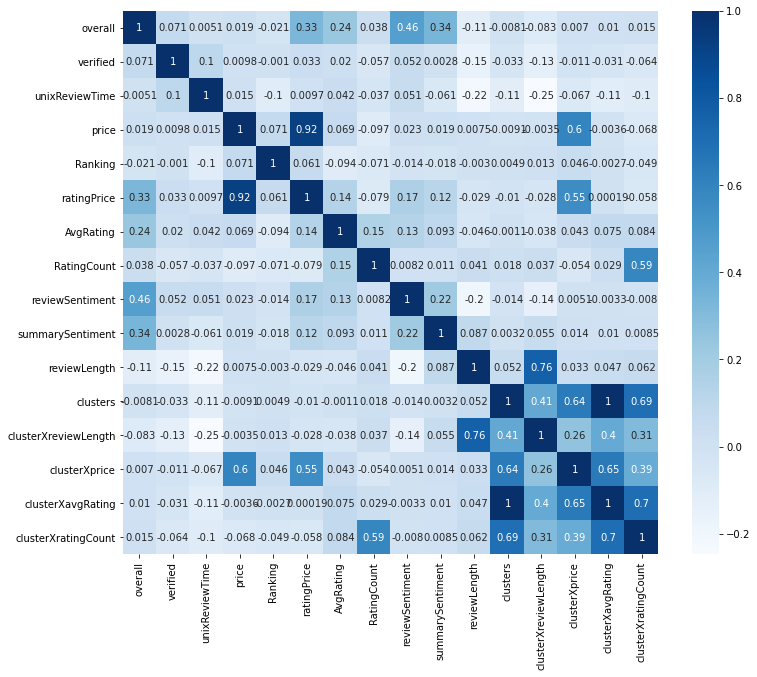

In [35]:
plt.figure(figsize = (12,10))
sns.heatmap(x_train.corr(), annot = True, cmap = 'Blues')


Now I'll need to predict the clusters for the training data as well as adding all of the additional features. It's important to use the PCA and KMeans that were fit to the training data to predict the test data. 

In [42]:
#Now I'll need to handle the categorical data. This means dropping some columns like reviewTime, reviewerID, asin, reviewerName
#reviewText, summary, category, catRank, rankCat. In the end, we need main_cat, brand and title.

x_train_categorical = pd.get_dummies(x_train[['main_cat', 'title', 'brand']])

In [43]:
print('Categorical Dummies will add %d columns to the data' %x_train_categorical.shape[1])

Categorical Dummies will add 444 columns to the data


In [44]:
#Now that I have the dummy variables the dataset is huge. I'll try to reduce the dimensionality with PCA on the categorical variables
pca = PCA(n_components = 60)
pca.fit(x_train_categorical)
x_train_pca = pca.transform(x_train_categorical)

Text(0.5, 1.0, 'Scree Plot for Categorical Dummy Variables')

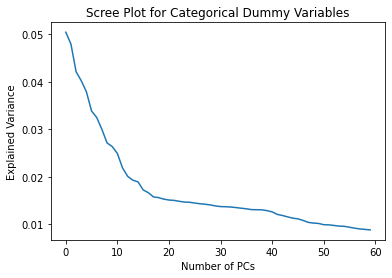

In [45]:
#I'll create a scree plot to extract the number of pertinent principle components.
plt.plot(pca.explained_variance_)
plt.xlabel('Number of PCs')
plt.ylabel('Explained Variance')
plt.title('Scree Plot for Categorical Dummy Variables')

In [39]:
x_train.shape

(59788, 29)

In [47]:
#It looks like I only need to include the first 2.
columns= []
for i in range(0, 21):
    columns.append('PCA' + str(i))
x_train_pca = pd.DataFrame(x_train_pca[:, 0:21], columns = columns)
# Add the columns to the training data.
x_train = pd.concat([x_train.reset_index(drop=True), x_train_pca.reset_index(drop = True)], axis=1)

In [48]:
x_train.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,category,...,PCA11,PCA12,PCA13,PCA14,PCA15,PCA16,PCA17,PCA18,PCA19,PCA20
0,5.0,1,"05 22, 2016",AREOC3C9WSI74,B00IOEFBKS,Tom Massart,Love it. So easy to clean and powerful suction...,Handy and powerful,1463875200,"['Home & Kitchen', 'Vacuums & Floor Care', 'Va...",...,0.057973,0.026758,0.006673,0.026023,0.012699,0.004673,-0.001962,0.009144,0.006143,0.005118
1,4.0,1,"10 18, 2016",A11H1ZI85AKHSD,B00MVWGQX0,TaMara,Makes a bold coffee. This coffee maker is of d...,"Beautiful Coffee Maker, Great Bold Cup of Coffee",1476748800,"['Home & Kitchen', 'Kitchen & Dining', 'Coffee...",...,0.010446,0.006419,0.001976,0.007415,0.003369,0.002720,0.000129,0.001336,0.000770,0.000233
2,5.0,1,"12 23, 2011",A2XAINGEZECR9J,B00005UP2N,Linzie,I had been wanting to buy a KitchenAid for a L...,Just Fabulous!,1324598400,"['Home & Kitchen', 'Kitchen & Dining', 'Small ...",...,-0.139195,-0.308115,1.163774,0.681155,0.063220,0.038552,0.003164,0.024894,0.009031,0.004186
3,5.0,1,"12 6, 2014",A26PM5EL75HGL6,B0091YYUAM,Skeeter,Makes cleaning ceramic tile floor so much easi...,Makes cleaning ceramic tile floor so much easi...,1417824000,"['Home & Kitchen', 'Vacuums & Floor Care', 'St...",...,-0.246602,1.193199,0.083695,0.233020,0.049201,0.032810,-0.000243,0.024836,0.008912,0.003937
4,5.0,1,"09 16, 2016",A1PCY719UWTFKU,B00COK3FD8,Jane Newhagen,Why didn't I do this before? I recycled all my...,Why didn't I do this before?,1473984000,"['Home & Kitchen', 'Kitchen & Dining', 'Storag...",...,-0.128938,-0.252325,-0.788620,1.109506,0.068834,0.042716,0.002526,0.027837,0.009225,0.005234


In [49]:
#First I'll add the clusters. I need to create a DF that drops the engineered features and the categorical features to train the KMeans model

obs = []
[obs.append(col) for col in x_test.columns if x_test[col].dtype == 'O']


#Predict the training clusters
x_test_clf = x_test.drop(obs, axis = 1)
pred_clusters = kmeans.predict(x_test_clf)
x_test['clusters'] = pred_clusters

In [50]:
#Create an interaction term for cluster_reviewLength
x_test['clusterXreviewLength'] = x_test['clusters']*x_test['reviewLength']

#Create an interaction between cluster and overall
x_test['clusterXprice'] = x_test['clusters']*x_test['price']

#Create an interaction term between cluster and average rating
x_test['clusterXavgRating'] = x_test['clusters']*x_test['AvgRating']

x_test['clusterXratingCount'] = x_test['clusters']*x_test['RatingCount']

In [55]:
x_test_categorical = pd.get_dummies(x_test[['main_cat', 'title', 'brand']])
x_test_pca = pca.transform(x_test_categorical)
x_test_pca = pd.DataFrame(x_test_pca[:, 0:21], columns = columns)
x_test = pd.concat([x_test.reset_index(drop=True), x_test_pca.reset_index(drop=True)], axis = 1)

In [56]:
#Now check to ensure the dimensions and columns match
print('Dimensions of x_train are:', x_train.shape)
print('Dimensions of x_test are:', x_test.shape)
print('Coulmns of x_train are:', x_train.columns)
print('Columns of x_test are:', x_test.columns)

Dimensions of x_train are: (109702, 50)
Dimensions of x_test are: (36568, 50)
Coulmns of x_train are: Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'category',
       'title', 'brand', 'rank', 'main_cat', 'price', 'rankCat', 'catRank',
       'Ranking', 'ratingPrice', 'AvgRating', 'RatingCount', 'reviewSentiment',
       'summarySentiment', 'reviewLength', 'clusters', 'clusterXreviewLength',
       'clusterXprice', 'clusterXavgRating', 'clusterXratingCount', 'PCA0',
       'PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9',
       'PCA10', 'PCA11', 'PCA12', 'PCA13', 'PCA14', 'PCA15', 'PCA16', 'PCA17',
       'PCA18', 'PCA19', 'PCA20'],
      dtype='object')
Columns of x_test are: Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'category',
       'title', 'brand', 'rank', 'main_cat', 'price', 'rankCa

Now I'll just save the data with the new features. 

In [57]:
#Save the data to a csv file
x_train.to_csv('Data/x_train200k.csv', index = False)
y_train.to_csv('Data/y_train200k.csv', index = False)
x_test.to_csv('Data/x_test200k.csv', index = False)
y_test.to_csv('Data/y_test200k.csv', index = False)